# Logistic Regression


### 1. Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, recall_score, balanced_accuracy_score, roc_auc_score, precision_score

In [2]:
def import_dataset(filename):
    """
    Import the dataset from the path.

    Parameters
    ----------
        filename : str
            filename with path

    Returns
    -------
        data : DataFrame

    Examples
    --------
        bank_mkt = import_dataset("../data/BankMarketing.csv")
    """
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "category",
                                      "day_of_week": "category",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # Drop 12 duplicated rows
    bank_mkt = bank_mkt.drop_duplicates().reset_index(drop=True)
    # reorder categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    bank_mkt["month"] = bank_mkt["month"].cat.reorder_categories(["mar", "apr", "jun", "jul", "may", "aug", "sep", "oct", "nov", "dec"], ordered=True)
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].cat.reorder_categories(["mon", "tue", "wed", "thu", "fri"], ordered=True)
    return bank_mkt

In [4]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

### 2. Data Preparation

In [5]:
def benchmark(data, preprocessor, clf):
    """
    Benchmark preprocessor and clf's performance on train, validation and test sets. 
    All the data transformation should be handled by preprocessor and estimation should be handled by clf.
    
    Parameters
    ----------
        data : DataFrame
        
        preprocessor : Pipeline
        
        clf : estimator
        
        name : str, default = None
        
        compare_to: DataFrame, default = None
        
    """
    X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, preprocessor)
    X_sets = [X_ttrain, X_validate, X_test]
    y_sets = [y_ttrain, y_validate, y_test]
    
    metric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "AP"]
    set_names = ["Train", "Validate", "Test"]
    metric_df = pd.DataFrame(index=metric_names, columns=set_names)
    
    try:
        clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
    except (ValueError, TypeError):
        clf.fit(X_ttrain, y_ttrain)
        
    for name, X, y in zip(set_names, X_sets, y_sets):
        # Re-fit model on train set before test set evaluation except CatBoost
        if name == "Test":
            try:
                clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
            except (ValueError, TypeError):
                clf.fit(X_train, y_train)
                
        y_pred = clf.predict(X)
        
        try:
            y_score = clf.decision_function(X)
        except AttributeError:
            y_score = clf.predict_proba(X)[:, 1]
            
        metrics = [recall_score(y, y_pred, pos_label=0),
                   recall_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   roc_auc_score(y, y_score),
                   recall_score(y, y_pred),
                   precision_score(y, y_pred),
                   average_precision_score(y, y_score)]
        metric_df[name] = metrics
        
    return metric_df

In [6]:
#### Define plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])): 
         plt.text(j, i, format(cm[i, j], fmt), 
                  horizontalalignment="center", fontsize=16,                  
                  color="white" if cm[i, j] > thresh else "black") 
    plt.ylabel('True label')     
    plt.xlabel('Predicted label')     
    plt.tight_layout()


In [7]:
def split_dataset(data, preprocessor, random_state=42):
    """
    Split dataset into train, test and validation sets using preprocessor.
    Because the random state of validation set is not specified, the validation set will be different each time when the function is called.

    Parameters
    ----------
        data : DataFrame

        preprocessor : Pipeline

    Returns
    -------
        datasets : tuple

    Examples
    --------
        from sklearn.preprocessing import OrdinalEncoder
        data = import_dataset("../data/BankMarketing.csv").interpolate(method="pad").loc[:, ["job", "education", "y"]]
        # To unpack all train, test, and validation sets 
        X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack train and test sets.
        X_train, y_train, X_test, y_test, *other_sets = split_dataset(data, OrdinalEncoder())
        # To unpack test and validation set
        *other_sets, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack only train set.
        X_train, y_train, *other_sets = split_dataset(data, OneHotEncoder())
    """
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    for train_index, test_index in train_test_split.split(data.drop("y", axis=1), data["y"]):
        train_set = data.loc[train_index].reset_index(drop=True)
        test_set = data.loc[test_index].reset_index(drop=True)

    y_train = train_set["y"].astype("int").to_numpy()
    y_test = test_set["y"].astype("int").to_numpy()
    X_train = preprocessor.fit_transform(train_set, y_train)
    X_test = preprocessor.transform(test_set)
        
    train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for ttrain_index, validate_index in train_validate_split.split(X_train, y_train):
        ttrain_set = train_set.loc[ttrain_index].reset_index(drop=True)
        validate_set = train_set.loc[validate_index].reset_index(drop=True)
    
    y_ttrain = ttrain_set["y"].astype("int").to_numpy()
    y_validate = validate_set["y"].astype("int").to_numpy()
    X_ttrain = preprocessor.fit_transform(ttrain_set, y_ttrain)
    X_validate = preprocessor.transform(validate_set)
    
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        X_ttrain = X_ttrain.to_numpy()
        X_validate = X_validate.to_numpy()

    return (X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate)

In [8]:
def cat_encode(X,
               drop=["duration", "y"],
               cut=None,
               cyclic=None,
               target=None):
    """
    Encode and transform categorical data into numerical values.
    
    Parameters
    ----------
        X : DataFrame
        
        drop : list, default = ["duration", "y"]
        
        cut : list
        
        cyclic : list
        
        target : list
    
    Returns
    -------
        X : DataFrame

    Examples
    --------
    bank_mkt = import_dataset("../data/BankMarketing.csv")
    X = cat_encode(bank_mkt)
    """
    X = X.copy()
    
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3.
    month_map = {"mar": 3,
                 "apr": 4,
                 "may": 5,
                 "jun": 6,
                 "jul": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    X["month"] = X["month"].replace(month_map).astype("Int64")
    
    if cut != None:
        if "pdays" in cut:
            X["pdays"] = X["pdays"].fillna(-1)
            # Clients who have been contacted but do not have pdays record
            X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
            # Cut pdays into categories
            X["pdays"] = pd.cut(X["pdays"], [0, 3, 5, 10, 15, 30, 1000], labels=[3, 5, 10, 15, 30, 1000], include_lowest=True).astype("Int64")
    else:
        # Fill missing values in pdays as 999
        X["pdays"] = X["pdays"].fillna(999)
    
    if cyclic != None:
        if "month" in cyclic:
            X['month_sin'] = np.sin(2 * np.pi * X["month"]/12)
            X['month_cos'] = np.cos(2 * np.pi * X["month"]/12)
            X = X.drop("month", axis=1)
        if "day_of_week" in cyclic:
            X["day_of_week"] = X["day_of_week"].cat.codes
            X['day_sin'] = np.sin(2 * np.pi * X["day_of_week"]/5)
            X['day_cos'] = np.cos(2 * np.pi * X["day_of_week"]/5)
            X = X.drop("day_of_week", axis=1)
    
    # Transform target encoded feature as str
    if target != None:
        X[target] = X[target].astype("str")
        
    # Drop features
    X = X.drop(drop, axis=1)
    
    # Other categorical features will be coded as its order in pandas categorical index
    X = X.apply(lambda x: x.cat.codes if pd.api.types.is_categorical_dtype(x) else (x.astype("Int64") if pd.api.types.is_bool_dtype(x) else x))
    
    # Fill missing values as -1
    X = X.fillna(-1)
    
    return X

In [9]:
cat_encoder = FunctionTransformer(cat_encode)

freq_features = ["job", "marital", "education", "default", "housing", "loan"]

freq_imputer = ColumnTransformer([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"), freq_features)
], remainder="passthrough")

freq_encoder = make_pipeline(cat_encoder, freq_imputer)

In [10]:
X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, freq_encoder)

### 3. Logistic Regression

##### Logistic Model
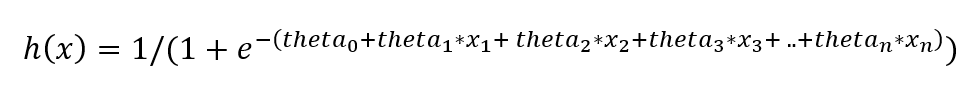
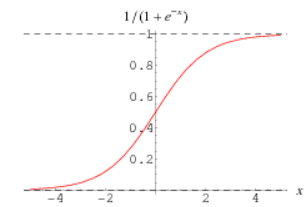

In [11]:
#### Use freq train set
from sklearn.linear_model import LogisticRegression
lrmodel = LogisticRegression(class_weight='balanced',max_iter=10000) ### set two parameters!!!!
lrmodel.fit(X_train, y_train)
y_train_pred = lrmodel.predict(X_train)
#### model measures for training data
cmtr = confusion_matrix(y_train, y_train_pred)
acctr = accuracy_score(y_train, y_train_pred)
aps_train = average_precision_score(y_train, y_train_pred)

#### Use freq test set
lrmodel.fit(X_test, y_test)
y_test_pred = lrmodel.predict(X_test)
#### model measures for testing data
cmte = confusion_matrix(y_test, y_test_pred)
accte = accuracy_score(y_test, y_test_pred)
aps_test = average_precision_score(y_test, y_test_pred)

print('Confusion Matrix:\n',cmtr,'\nAccuracy Score:\n',acctr, '\nAPS:\n',aps_train)
print('Confusion Matrix:\n',cmte,'\nAccuracy Score:\n',accte, '\nAPS:\n',aps_test)

Confusion Matrix:
 [[21241  7988]
 [ 1119  2592]] 
Accuracy Score:
 0.7235276259866423 
APS:
 0.20508794070054304
Confusion Matrix:
 [[5679 1629]
 [ 277  651]] 
Accuracy Score:
 0.7685769791160758 
APS:
 0.23393200343166073


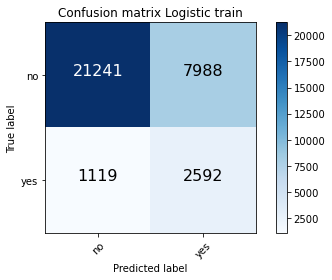

In [12]:
#### Plot confusion matrix for train-prediction
np.set_printoptions(precision=2)
class_names = ['no', 'yes']
plt.figure()
plot_confusion_matrix(cmtr, classes=class_names,
                      title='Confusion matrix Logistic train')

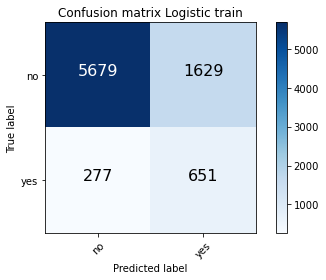

In [13]:
#### Plot confusion matrix for test-prediction
np.set_printoptions(precision=2)
class_names = ['no', 'yes']
plt.figure()
plot_confusion_matrix(cmte, classes=class_names,
                      title='Confusion matrix Logistic train')

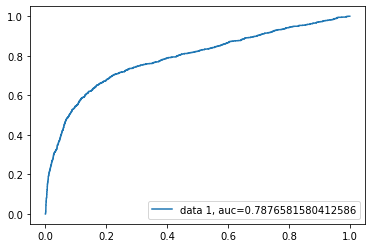

In [14]:
#### Plot AUC for test set
y_pred_proba = lrmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [15]:
benchmark(bank_mkt, freq_encoder, lrmodel)

,Train,Validate,Test
TNR,0.791387,0.788060,0.733306
TPR,0.658471,0.649596,0.728448
bACC,0.724929,0.718828,0.730877
ROC,0.776031,0.773543,0.773593
REC,0.658471,0.649596,0.728448
PRE,0.286112,0.280070,0.257524
AP,0.421317,0.430669,0.422791


### 4.  Grid Search 


In [17]:
#### Try the 1st GridSearch param_grid combination:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score
from sklearn.model_selection import GridSearchCV
lrmodel = LogisticRegression(class_weight='balanced', max_iter=10000)

#### Grid Search
param_grid = {'penalty': ['l2'],
              'C':[0.001,.009,0.01,.09,1,5,10,25,50,100]}
GS_lrmodel_1 = GridSearchCV(lrmodel, param_grid, scoring='recall')
GS_lrmodel_1.fit(X_train, y_train)
lrmodel_gs1 = lrmodel.set_params(**GS_lrmodel_1.best_params_)

#### use calibrated model on train set
lrmodel_gs1.fit(X_train, y_train)
y_train_pred = lrmodel_gs1.predict(X_train)
cmtr_gs1 = confusion_matrix(y_train, y_train_pred)
acctr_gs1 = accuracy_score(y_train, y_train_pred)
aps_train_gs1 = average_precision_score(y_train, y_train_pred)
#### test the model
lrmodel_gs1.fit(X_test, y_test)
y_test_pred = lrmodel_gs1.predict(X_test)
cmte_gs1 = confusion_matrix(y_test, y_test_pred)
accte_gs1 = accuracy_score(y_test, y_test_pred)
aps_test_gs1 = average_precision_score(y_test, y_test_pred)

print('Confusion Matrix:\n',cmtr_gs1,'\nAccuracy Score:\n',acctr_gs1, '\nAPS:\n',aps_train_gs1)
print('Confusion Matrix:\n',cmte_gs1,'\nAccuracy Score:\n',accte_gs1, '\nAPS:\n',aps_test_gs1)
print('best parameters:',GS_lrmodel_1.best_params_)

Confusion Matrix:
 [[22160  7069]
 [ 1186  2525]] 
Accuracy Score:
 0.7493928354584092 
APS:
 0.21507867663898383
Confusion Matrix:
 [[5359 1949]
 [ 252  676]] 
Accuracy Score:
 0.7327586206896551 
APS:
 0.2181901524087051
best parameters: {'C': 0.001, 'penalty': 'l2'}


In [18]:
benchmark(bank_mkt, freq_encoder, lrmodel_gs1)

,Train,Validate,Test
TNR,0.753710,0.752822,0.765326
TPR,0.681037,0.699461,0.711207
bACC,0.717374,0.726142,0.738266
ROC,0.765923,0.780018,0.780575
REC,0.681037,0.699461,0.711207
PRE,0.259864,0.264257,0.277895
AP,0.410849,0.462047,0.430201


In [ ]:
#### Try the 2nd GridSearch param_grid combination:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score
from sklearn.model_selection import GridSearchCV
lrmodel_gs = LogisticRegression(class_weight='balanced',max_iter=10000)

#### Grid Search
param_grid = {"C":np.logspace(-3,3,7), 
              "penalty":["l1","l2"],
              "solver": ["saga"]}
GS_lrmodel_2 = GridSearchCV(lrmodel_gs, param_grid, cv=10)
GS_lrmodel_2.fit(X_train, y_train)
lrmodel_gs2 = lrmodel_gs.set_params(**GS_lrmodel_2.best_params_)

#### use calibrated model on train set
lrmodel_gs2.fit(X_train, y_train)
y_train_pred = lrmodel_gs2.predict(X_train)
cmtr_gs2 = confusion_matrix(y_train, y_train_pred)
acctr_gs2 = accuracy_score(y_train, y_train_pred)
aps_train_gs2 = average_precision_score(y_train, y_train_pred)
#### test the model
lrmodel_gs2.fit(X_test, y_test)
y_test_pred = lrmodel_gs2.predict(X_test)
cmte_gs2 = confusion_matrix(y_test, y_test_pred)
accte_gs2 = accuracy_score(y_test, y_test_pred)
aps_test_gs2 = average_precision_score(y_test, y_test_pred)

print('Confusion Matrix:\n',cmtr_gs2,'\nAccuracy Score:\n',acctr_gs2, '\nAPS:\n',aps_train_gs2)
print('Confusion Matrix:\n',cmte_gs2,'\nAccuracy Score:\n',accte_gs2, '\nAPS:\n',aps_test_gs2)
print('best parameters:',GS_lrmodel_2.best_params_)

In [20]:
benchmark(bank_mkt, freq_encoder, lrmodel_gs2)

,Train,Validate,Test
TNR,0.787709,0.783955,0.793103
TPR,0.663860,0.648248,0.678879
bACC,0.725784,0.716101,0.735991
ROC,0.777518,0.769845,0.783334
REC,0.663860,0.648248,0.678879
PRE,0.284211,0.275803,0.294118
AP,0.427567,0.420256,0.427467


### 5.  Describe Logistic Model

In [ ]:
from sklearn.linear_model import LogisticRegression
lrmodel = LogisticRegression(class_weight='balanced',max_iter=1000)
lrmodel.fit(X_train, y_train)

print("Training set score: {:.3f}".format(lrmodel.score(X_train, y_train)))

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y_test, X_test)
result=logit_model.fit()
print(result.summary())